Lee, E., Baek, K. & Kim, J. (2021). Datasets on South Korean manufacturing factories’ electricity consumption and demand response participation. figshare. Dataset. https://doi.org/10.6084/m9.figshare.14822256.v9

https://figshare.com/ndownloader/files/34134648


Sathishkumar, V.E., Changsun, S. & Yongyun C. (2023). Steel Industry Energy Consumption. UCI Machine Learning Repository. https://doi.org/10.24432/C52G8C

https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption

the total electricity consumption (kW)

### download and setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
import statistics as s
import requests
import random
import shutil
import os

In [ ]:
def get_sample(mu=10, sigma=2, seed=42, size=1):
    n = s.NormalDist(mu=mu, sigma=sigma)
    samples = n.samples(size, seed=seed)
    return samples

def download_file(url):
    local_filename = url.split('/')[-1]
    if not os.path.exists(local_filename):
      with requests.get(url, stream=True) as r:
          with open(local_filename, 'wb') as f:
              shutil.copyfileobj(r.raw, f)
    return local_filename

In [ ]:
file_name = download_file("https://figshare.com/ndownloader/files/34134648")
wdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

In [ ]:
!unzip -o {file_name}

Archive:  34134648
   creating: Data_list/DR_information/
  inflating: Data_list/DR_information/Industy DR Information.xlsx  
   creating: Data_list/Factories/
  inflating: Data_list/Factories/Cement_1.csv  
  inflating: Data_list/Factories/Cement_2.csv  
  inflating: Data_list/Factories/Forge_1.csv  
  inflating: Data_list/Factories/Forge_2.csv  
  inflating: Data_list/Factories/Metal_1.csv  
  inflating: Data_list/Factories/Metal_2.csv  
  inflating: Data_list/Factories/Metal_3.csv  
  inflating: Data_list/Factories/Paper.csv  
  inflating: Data_list/Factories/Steel_1.csv  
  inflating: Data_list/Factories/Steel_2.csv  
   creating: Data_list/System_demand/
  inflating: Data_list/System_demand/System load(Korea, 2019.03~06.).csv  


In [ ]:
file_name = download_file("https://archive.ics.uci.edu/static/public/851/steel+industry+energy+consumption.zip")

In [ ]:
!unzip -o {file_name}

Archive:  steel+industry+energy+consumption.zip
  inflating: Steel_industry_data.csv  


In [ ]:
profile1 = "./Data_list/Factories/Steel_1.csv"
profile2 = "./Data_list/Factories/Steel_2.csv"
profile3 = "./Steel_industry_data.csv"

### Profile A

In [ ]:
# 1 March 2019 to 30 September 2019
profile = pd.read_csv(profile1, parse_dates=True).rename(columns={'Power consumption': 'P[kW]'})
profile['Time'] = pd.to_datetime(profile['Time'], errors='coerce')
profile.set_index('Time', inplace=True)

In [ ]:
start = pd.to_datetime('2019-01-01') #profile.index.min()
end = start+relativedelta(years=1)
idx = pd.date_range(start=start, end=end, freq='1W').shift(1, freq='D')
idx = list(zip(idx, idx.shift(7, freq='D')))
weeklydata = pd.DataFrame()
for i in idx:
    week = profile.loc[i[0]:i[1]-relativedelta(seconds=1)].copy()
    if len(week):
        week.columns = [str(week.index.min()).split(' ')[0]]
        week.index = week.index - week.index.min()
        weeklydata = pd.concat([weeklydata, week], axis=1)
all_mondays = [str(i[0]).split(' ')[0] for i in idx]

<ipython-input-7-e0251c6a3536>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + wdays)


Text(0, 0.5, '')

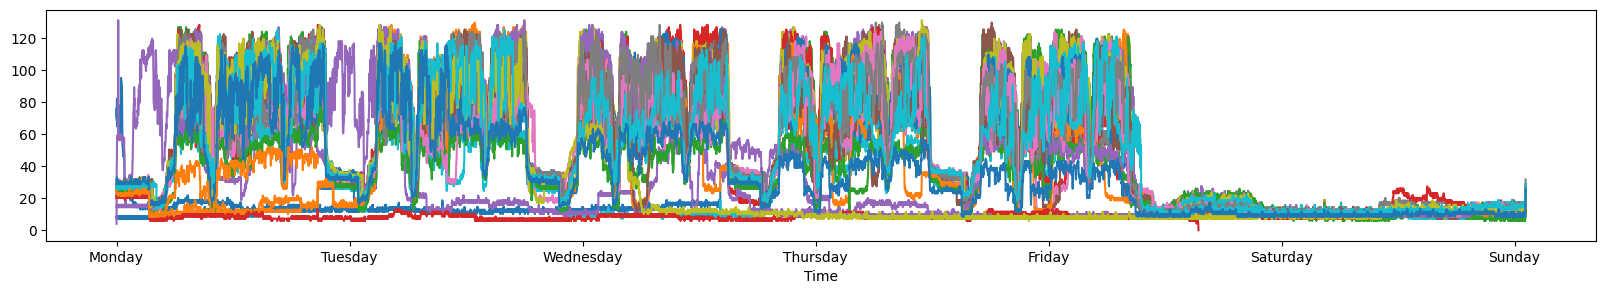

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
#ax.set_xticklabels([str(i).split('days ')[1] for i in weeklydata.index])
ax.set_xticklabels([''] + wdays)
for c in weeklydata.columns:
  sns.lineplot(ax=ax,
               x=weeklydata.index,
               y=weeklydata[c],
               data=weeklydata)
ax.set_ylabel('')

In [ ]:
random.seed(13)
generated_weeklydata = pd.DataFrame()
for idx, i in weeklydata.iterrows():
    sample = get_sample(mu=i.mean(), sigma=i.std(), size=len(all_mondays))
    sample = np.clip(sample, 0, max(sample))
    sample = pd.concat([pd.Series(sample, index=all_mondays)])
    sample.index = pd.to_datetime(sample.index, errors='coerce') + idx
    generated_weeklydata = pd.concat([generated_weeklydata, sample])
generated_weeklydata.sort_index(inplace=True)
generated_weeklydata = generated_weeklydata.loc[:datetime.date.max.replace(year=profile.index.max().year)+relativedelta(seconds=3599)].rename(columns={0: 'P[kW]'})

<ipython-input-8-622ebbc4195e>:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  generated_weeklydata = pd.concat([generated_weeklydata, sample])


<Axes: >

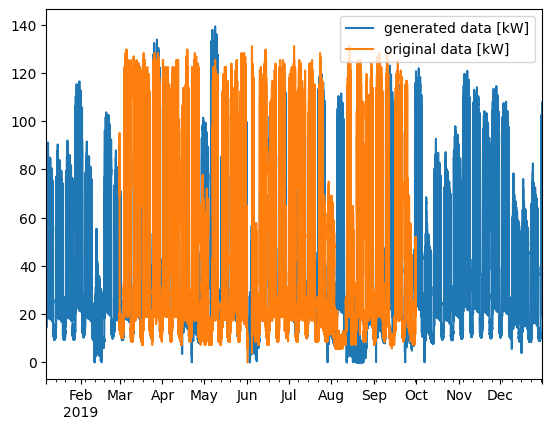

In [ ]:
profile.rename(columns={'P[kW]': 'original data [kW]'}).combine_first(generated_weeklydata.rename(columns={'P[kW]': 'generated data [kW]'})).plot()

<Axes: >

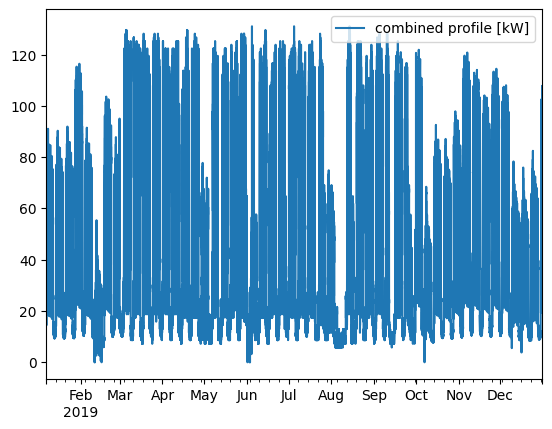

In [ ]:
full_profile = profile.combine_first(generated_weeklydata)
full_profile.rename(columns={'P[kW]': 'combined profile [kW]'}).plot()

total_capacity: 23966192.117603328 target capacity: 1150000000.0 scaled capacity: 1150000000.0


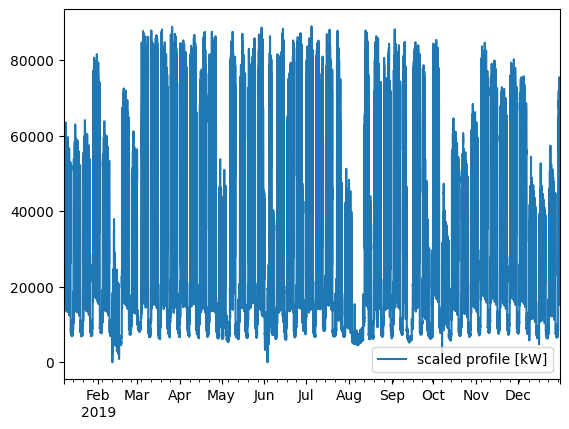

In [ ]:
target_capacity = 1.15 * 10 ** 9 # 1.15 TW -> kW
profile_name = 'profileA_1.15TW.csv'
total_capacity = full_profile['P[kW]'].sum()
scaled_profile = full_profile.copy()
scaled_profile['P[kW]'] = scaled_profile['P[kW]'] * target_capacity / total_capacity
scaled_profile = scaled_profile.resample("15min").sum()
scaled_profile.rename(columns={'P[kW]': 'scaled profile [kW]'}).plot()
print('total_capacity:', total_capacity, 'target capacity:', target_capacity, 'scaled capacity:', scaled_profile['P[kW]'].sum())
scaled_profile.reset_index().rename(columns={'index': 'Time'}).to_csv(profile_name, index=False)

### Profile B

In [ ]:
# 1 March 2019 to 30 September 2019
profile = pd.read_csv(profile2, parse_dates=True).rename(columns={'Power consumption': 'P[kW]'})
profile['Time'] = pd.to_datetime(profile['Time'], errors='coerce')
profile.set_index('Time', inplace=True)

In [ ]:
start = pd.to_datetime('2019-01-01') #profile.index.min()
end = start+relativedelta(years=1)
idx = pd.date_range(start=start, end=end, freq='1W').shift(1, freq='D')
idx = list(zip(idx, idx.shift(7, freq='D')))
weeklydata = pd.DataFrame()
for i in idx:
    week = profile.loc[i[0]:i[1]-relativedelta(seconds=1)].copy()
    if len(week):
        week.columns = [str(week.index.min()).split(' ')[0]]
        week.index = week.index - week.index.min()
        weeklydata = pd.concat([weeklydata, week], axis=1)
all_mondays = [str(i[0]).split(' ')[0] for i in idx]

<ipython-input-22-e0251c6a3536>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + wdays)


Text(0, 0.5, '')

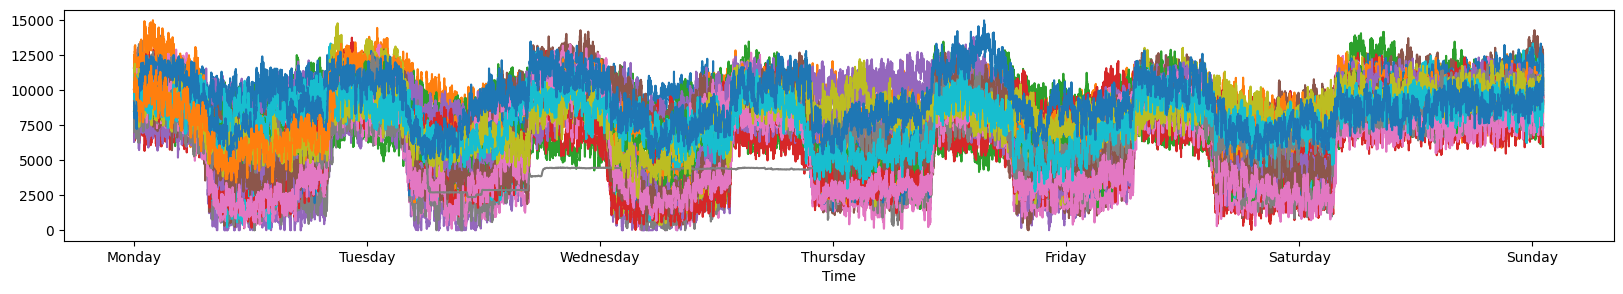

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
#ax.set_xticklabels([str(i).split('days ')[1] for i in weeklydata.index])
ax.set_xticklabels([''] + wdays)
for c in weeklydata.columns:
  sns.lineplot(ax=ax,
               x=weeklydata.index,
               y=weeklydata[c],
               data=weeklydata)
ax.set_ylabel('')

In [ ]:
random.seed(13)
generated_weeklydata = pd.DataFrame()
for idx, i in weeklydata.iterrows():
    sample = get_sample(mu=i.mean(), sigma=i.std(), size=len(all_mondays))
    sample = np.clip(sample, 0, max(sample))
    sample = pd.concat([pd.Series(sample, index=all_mondays)])
    sample.index = pd.to_datetime(sample.index, errors='coerce') + idx
    generated_weeklydata = pd.concat([generated_weeklydata, sample])
generated_weeklydata.sort_index(inplace=True)
generated_weeklydata = generated_weeklydata.loc[:datetime.date.max.replace(year=profile.index.max().year)+relativedelta(seconds=3599)].rename(columns={0: 'P[kW]'})

<ipython-input-23-622ebbc4195e>:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  generated_weeklydata = pd.concat([generated_weeklydata, sample])


<Axes: >

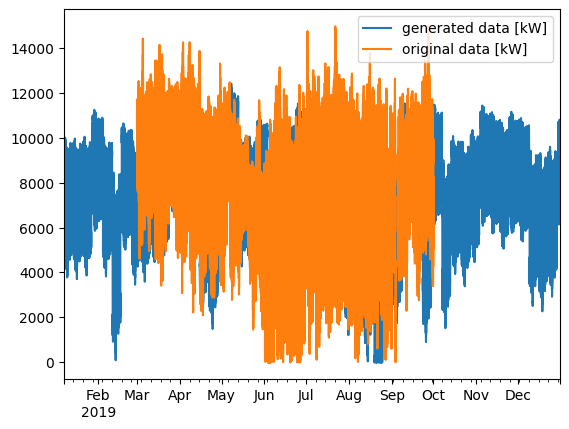

In [ ]:
profile.rename(columns={'P[kW]': 'original data [kW]'}).combine_first(generated_weeklydata.rename(columns={'P[kW]': 'generated data [kW]'})).plot()

<Axes: >

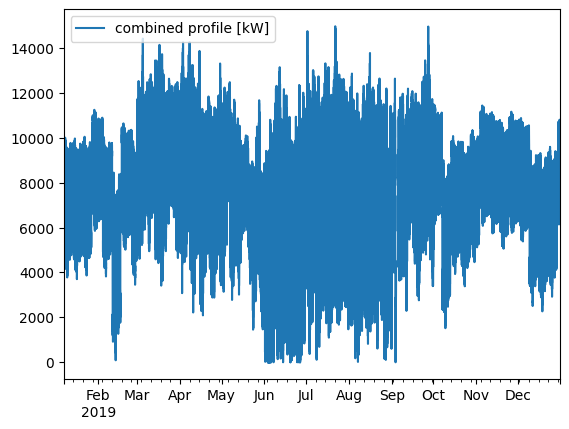

In [ ]:
full_profile = profile.combine_first(generated_weeklydata)
full_profile.rename(columns={'P[kW]': 'combined profile [kW]'}).plot()

total_capacity: 3791532283.558405 target capacity: 1150000000.0 scaled capacity: 1149999999.9999998


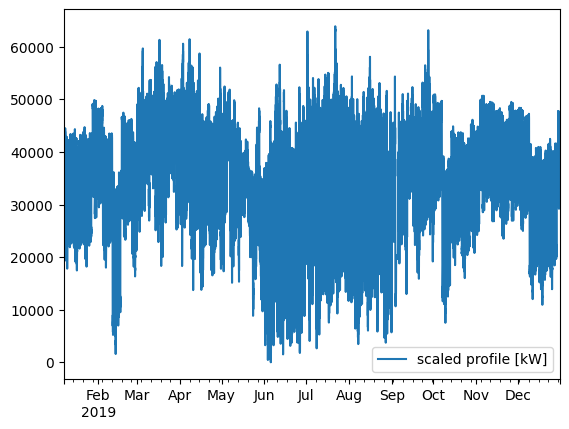

In [ ]:
target_capacity = 1.15 * 10 ** 9 # 1.15 TW -> kW
profile_name = 'profileB_1.15TW.csv'
total_capacity = full_profile['P[kW]'].sum()
scaled_profile = full_profile.copy()
scaled_profile['P[kW]'] = scaled_profile['P[kW]'] * target_capacity / total_capacity
scaled_profile = scaled_profile.resample("15min").sum()
scaled_profile.rename(columns={'P[kW]': 'scaled profile [kW]'}).plot()
print('total_capacity:', total_capacity, 'target capacity:', target_capacity, 'scaled capacity:', scaled_profile['P[kW]'].sum())
scaled_profile.reset_index().rename(columns={'index': 'Time'}).to_csv(profile_name, index=False)

### Profile C


In [ ]:
# 2018
profile = pd.read_csv(profile3, parse_dates=True).rename(columns={'Usage_kWh': 'P[kW]'})
profile['Time'] = pd.to_datetime(profile['date'], format=r'%d/%m/%Y  %H:%M', errors='coerce')
profile = profile[["Time", 'P[kW]']]#.dropna()
profile.set_index('Time', inplace=True)
profile.sort_index(inplace=True)

In [ ]:
start = pd.to_datetime('2018-01-01') #profile.index.min()
end = start+relativedelta(years=1)
idx = pd.date_range(start=start, end=end, freq='1W').shift(1, freq='D')
idx = list(zip(idx, idx.shift(7, freq='D')))
weeklydata = pd.DataFrame()
for i in idx:
    week = profile.loc[i[0]+relativedelta(seconds=15*60):i[1]-relativedelta(seconds=15*60)].copy()
    if len(week):
        week.columns = [str(week.index.min()).split(' ')[0]]
        week.index = week.index - week.index.min()
        weeklydata = pd.concat([weeklydata, week], axis=1)
all_mondays = [str(i[0]).split(' ')[0] for i in idx]

<ipython-input-104-e0251c6a3536>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + wdays)


Text(0, 0.5, '')

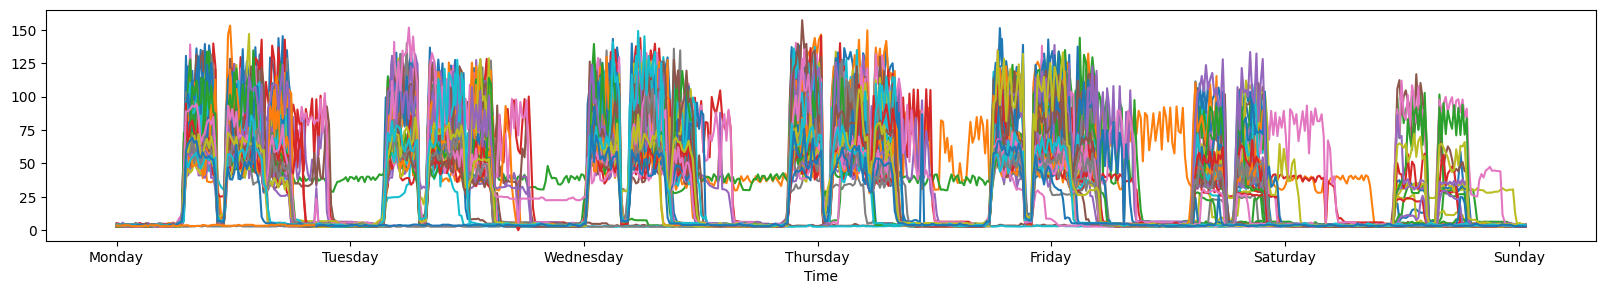

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
#ax.set_xticklabels([str(i).split('days ')[1] for i in weeklydata.index])
ax.set_xticklabels([''] + wdays)
for c in weeklydata.columns:
  sns.lineplot(ax=ax,
               x=weeklydata.index,
               y=weeklydata[c],
               data=weeklydata)
ax.set_ylabel('')

In [ ]:
random.seed(13)
generated_weeklydata = pd.DataFrame()
for idx, i in weeklydata.iterrows():
    sample = get_sample(mu=i.mean(), sigma=i.std(), size=len(all_mondays))
    sample = np.clip(sample, 0, max(sample))
    sample = pd.concat([pd.Series(sample, index=all_mondays)])
    sample.index = pd.to_datetime(sample.index, errors='coerce') + idx
    generated_weeklydata = pd.concat([generated_weeklydata, sample])
generated_weeklydata.sort_index(inplace=True)
generated_weeklydata = generated_weeklydata.loc[:datetime.date.max.replace(year=profile.index.max().year)+relativedelta(seconds=3599)].rename(columns={0: 'P[kW]'})

<ipython-input-105-622ebbc4195e>:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  generated_weeklydata = pd.concat([generated_weeklydata, sample])


<Axes: >

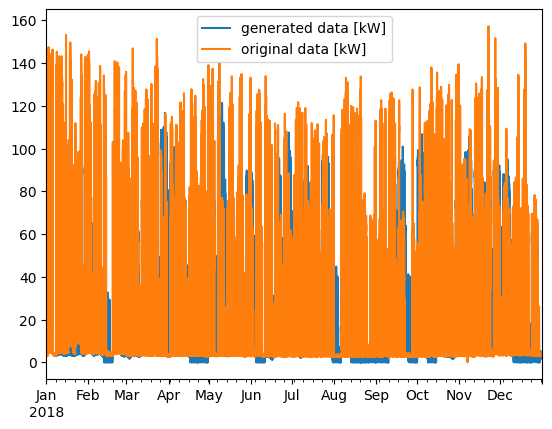

In [ ]:
profile.rename(columns={'P[kW]': 'original data [kW]'}).combine_first(generated_weeklydata.rename(columns={'P[kW]': 'generated data [kW]'})).plot()

<Axes: >

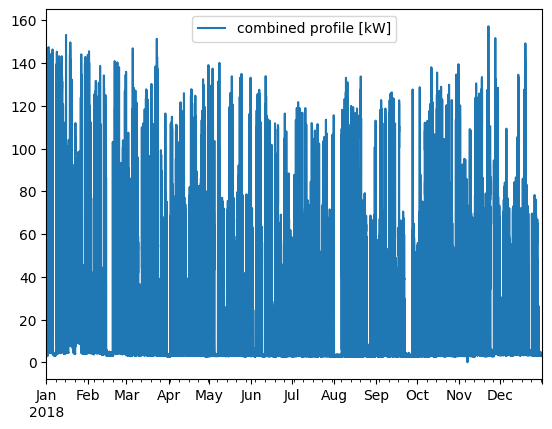

In [ ]:
full_profile = profile.combine_first(generated_weeklydata)
full_profile.rename(columns={'P[kW]': 'combined profile [kW]'}).plot()

total_capacity: 959636.71 target capacity: 1150000000.0 scaled capacity: 1150000000.0000002


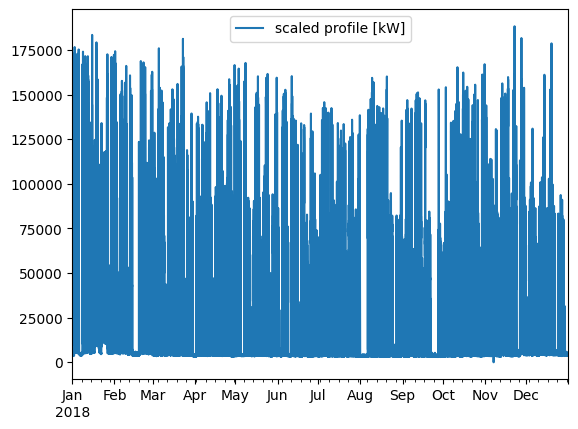

In [ ]:
target_capacity = 1.15 * 10 ** 9 # 1.15 TW -> kW
profile_name = 'profileС_1.15TW.csv'
total_capacity = full_profile['P[kW]'].sum()
scaled_profile = full_profile.copy()
scaled_profile['P[kW]'] = scaled_profile['P[kW]'] * target_capacity / total_capacity
scaled_profile = scaled_profile.resample("15min").sum()
scaled_profile.rename(columns={'P[kW]': 'scaled profile [kW]'}).plot()
print('total_capacity:', total_capacity, 'target capacity:', target_capacity, 'scaled capacity:', scaled_profile['P[kW]'].sum())
scaled_profile.reset_index().rename(columns={'index': 'Time'}).to_csv(profile_name, index=False)